In [1]:
# Install Prophet
!pip install prophet --quiet
!pip install matplotlib seaborn scikit-learn --quiet

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind


In [3]:
# Load the dataset (adjust path if needed)
df = pd.read_csv("/Users/janhavijadhav/Downloads/Extended_Theme_Park_Dataset.csv")

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Preview data
df.head()


,Date,Ticket_Price,Visitors,Weather_Score,Promotion_Flag,Holiday_Flag,Weekend_Flag
0,2023-01-01,87.48,3935,5.89,0,0,1
1,2023-01-02,84.31,3415,7.85,0,0,0
2,2023-01-03,88.24,3412,7.04,0,0,0
3,2023-01-04,92.62,4079,5.72,0,1,0
4,2023-01-05,83.83,3323,7.98,0,0,0


23:52:40 - cmdstanpy - INFO - Chain [1] start processing
23:52:40 - cmdstanpy - INFO - Chain [1] done processing


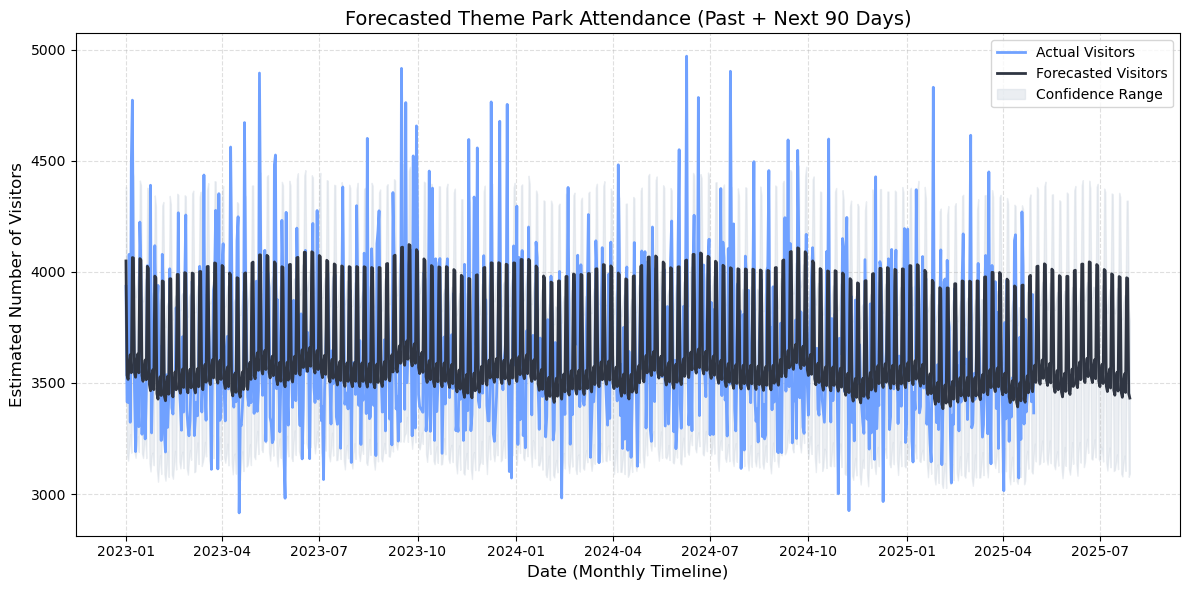

In [5]:
# Step 3: Forecasting Visitors with Prophet

from prophet.plot import plot_plotly, plot_components_plotly

# Prepare data (Prophet requires 'ds' and 'y' column names internally)
df_prophet = df[['Date', 'Visitors']].rename(columns={'Date': 'ds', 'Visitors': 'y'})

# Initialize model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(df_prophet)

# Future dates to forecast (next 90 days)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

# Merge for plotting
forecast_plot = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_plot = forecast_plot.rename(columns={
    'ds': 'Date',
    'yhat': 'Forecasted_Visitors',
    'yhat_lower': 'Lower_Bound',
    'yhat_upper': 'Upper_Bound'
})

# Plot 1: Visitor Forecast Over Time with Light Colors
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Visitors'], label='Actual Visitors', color='#70a1ff', linewidth=2)
plt.plot(forecast_plot['Date'], forecast_plot['Forecasted_Visitors'], label='Forecasted Visitors', color='#2f3542', linewidth=2)
plt.fill_between(forecast_plot['Date'], forecast_plot['Lower_Bound'], forecast_plot['Upper_Bound'], 
                 color='#ced6e0', alpha=0.4, label='Confidence Range')
plt.title("Forecasted Theme Park Attendance (Past + Next 90 Days)", fontsize=14)
plt.xlabel("Date (Monthly Timeline)", fontsize=12)
plt.ylabel("Estimated Number of Visitors", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


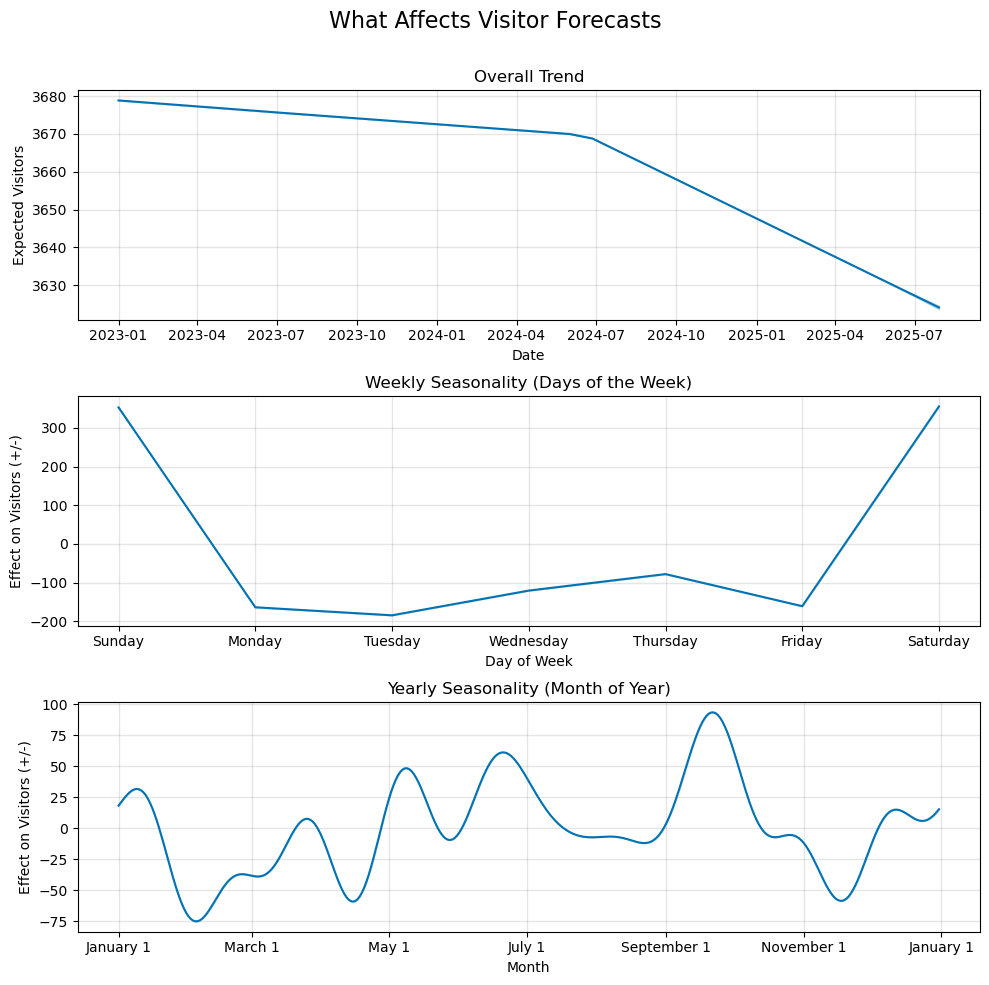

In [7]:
# Plot forecast components
fig = model.plot_components(forecast)

# Adjust titles and axis labels
fig.set_size_inches(10, 10)
fig.suptitle("What Affects Visitor Forecasts", fontsize=16)

# Adjust each subplot manually
axes = fig.get_axes()

# Trend
axes[0].set_title("Overall Trend")
axes[0].set_ylabel("Expected Visitors")
axes[0].set_xlabel("Date")

# Weekly
axes[1].set_title("Weekly Seasonality (Days of the Week)")
axes[1].set_ylabel("Effect on Visitors (+/-)")
axes[1].set_xlabel("Day of Week")

# Yearly
axes[2].set_title("Yearly Seasonality (Month of Year)")
axes[2].set_ylabel("Effect on Visitors (+/-)")
axes[2].set_xlabel("Month")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


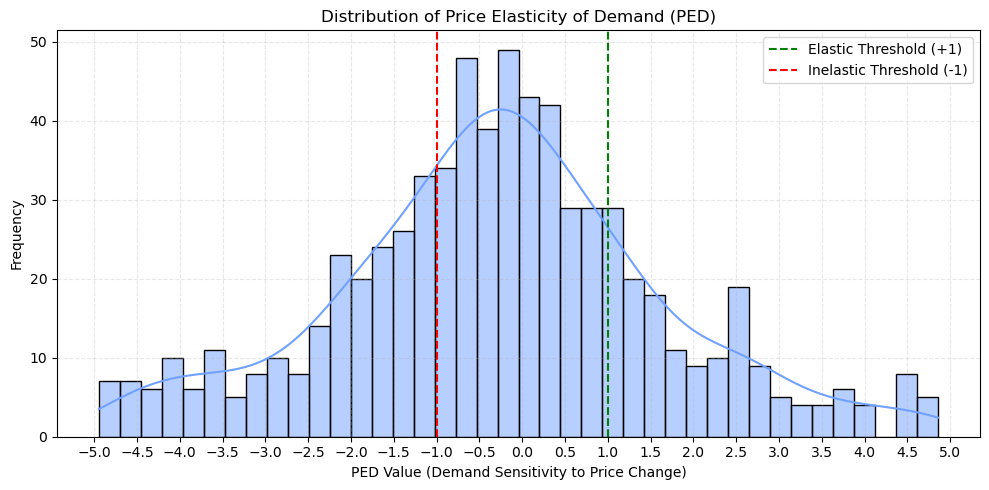

In [9]:
# Step 4: Price Elasticity of Demand (PED)

import matplotlib.ticker as ticker
# Calculate PED before plotting
df['Pct_Change_Visitors'] = df['Visitors'].pct_change()
df['Pct_Change_Price'] = df['Ticket_Price'].pct_change()
df['PED'] = df['Pct_Change_Visitors'] / df['Pct_Change_Price']

# Drop NaNs and filter out extreme outliers for better plot (optional)
df_elasticity = df.dropna(subset=['PED'])
df_elasticity = df_elasticity[df_elasticity['PED'].between(-5, 5)]

# Plot PED distribution with better axis control
plt.figure(figsize=(10, 5))
sns.histplot(df_elasticity['PED'], bins=40, kde=True, color='#70a1ff')

# Add reference lines
plt.axvline(1, color='green', linestyle='--', label='Elastic Threshold (+1)')
plt.axvline(-1, color='red', linestyle='--', label='Inelastic Threshold (-1)')

# Set custom ticks on X-axis (every 0.5)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.5))

# Graph titles and labels
plt.title("Distribution of Price Elasticity of Demand (PED)")
plt.xlabel("PED Value (Demand Sensitivity to Price Change)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/d0/tkdvqg753sbb7jhtkk5w8tgw0000gn/T/ipykernel_28003/1752221966.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_bin = df.groupby('Price_Bin')['Revenue'].mean().reset_index()
/var/folders/d0/tkdvqg753sbb7jhtkk5w8tgw0000gn/T/ipykernel_28003/1752221966.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Price_Bin', y='Revenue', data=revenue_by_bin, palette='Blues_d', edgecolor='black')


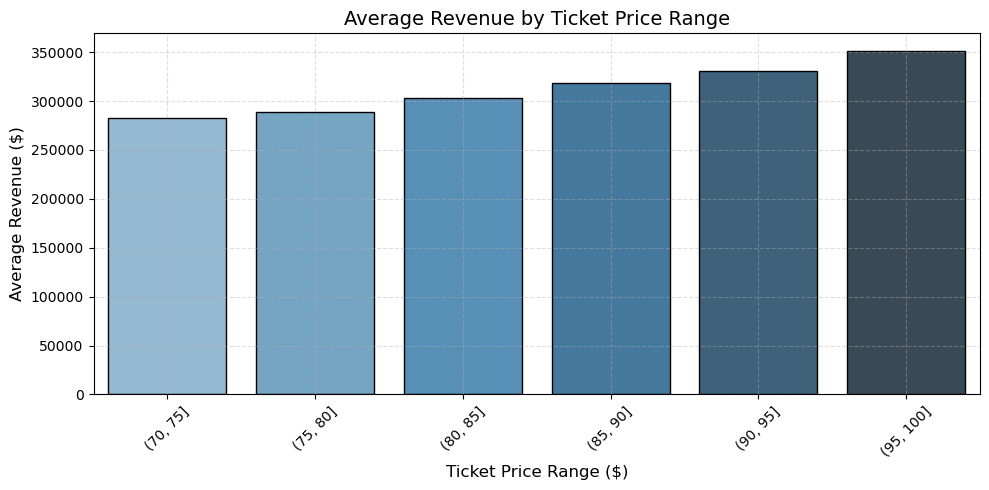

In [11]:
# Step 5 (Revenue vs Binned Ticket Prices)

# Calculate revenue first if not already done
df['Revenue'] = df['Ticket_Price'] * df['Visitors']

# Bin ticket prices (e.g., in $5 ranges)
df['Price_Bin'] = pd.cut(df['Ticket_Price'], bins=np.arange(70, 101, 5))  # 70-75, 75-80, ..., 95-100

# Group by bin and calculate average revenue
revenue_by_bin = df.groupby('Price_Bin')['Revenue'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x='Price_Bin', y='Revenue', data=revenue_by_bin, palette='Blues_d', edgecolor='black')

plt.title("Average Revenue by Ticket Price Range", fontsize=14)
plt.xlabel("Ticket Price Range ($)", fontsize=12)
plt.ylabel("Average Revenue ($)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [13]:
# Step 6: A/B Testing – Did Promotions Increase Visitors?

from scipy.stats import ttest_ind

# Step 6: Group A vs Group B
group_a = df[df['Promotion_Flag'] == 1]['Visitors']  # with promotion
group_b = df[df['Promotion_Flag'] == 0]['Visitors']  # without promotion

# T-test
t_stat, p_val = ttest_ind(group_a, group_b)

# Print results
print("A/B Testing: Promotions vs No Promotions")
print(f"Group A (Promotion) Average Visitors: {group_a.mean():.2f}")
print(f"Group B (No Promotion) Average Visitors: {group_b.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("Statistically significant — promotions likely increased visitors.")
else:
    print("Not statistically significant — promotions had no clear impact.")


A/B Testing: Promotions vs No Promotions
Group A (Promotion) Average Visitors: 3889.80
Group B (No Promotion) Average Visitors: 3605.83
T-statistic: 9.6262
P-value: 0.0000
Statistically significant — promotions likely increased visitors.


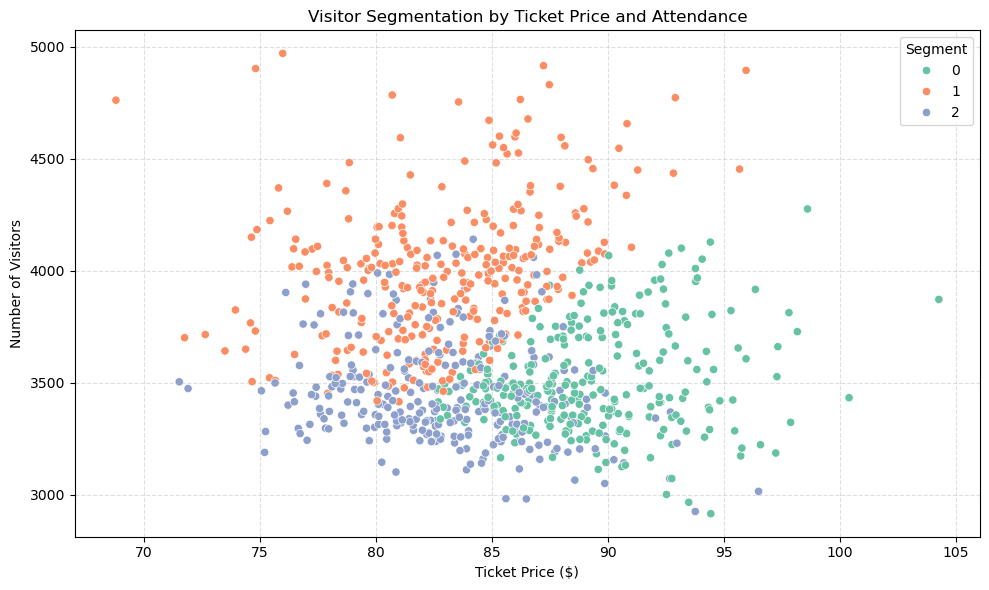

In [15]:
# Step 7: K-Means Clustering for Segmentation

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select relevant features
features = df[['Ticket_Price', 'Visitors', 'Weather_Score']]

# Standardize the features (important for clustering)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Fit KMeans model
kmeans = KMeans(n_clusters=3, random_state=42)
df['Segment'] = kmeans.fit_predict(scaled_features)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Ticket_Price', y='Visitors', hue='Segment', palette='Set2')
plt.title("Visitor Segmentation by Ticket Price and Attendance")
plt.xlabel("Ticket Price ($)")
plt.ylabel("Number of Visitors")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
